# **pips and imports**

In [ ]:
%%time
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
print(f"torch version: {torch.__version__}")
!pip install -U pip
try:
  import mat_discover
except:
  !pip install -UI mat_discover

%pip install pymatgen
%pip install CBFV
%pip install SMACT

# **You must restart the runtime after this step**


torch version: 1.12.0+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 7.9 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 57.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# imports
import pandas as pd
import numpy as np
import mat_discover
print(f"DiSCoVeR version {mat_discover.__version__}")
from mat_discover.mat_discover_ import Discover
from pymatgen.core.composition import Composition
import math
from os.path import join
from pathlib import Path
import crabnet
print(f"CrabNet version {crabnet.__version__}")
from CBFV import composition
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import smact
from smact.screening import pauling_test
import itertools
from fractions import Fraction
import functools

DiSCoVeR version 2.2.3
CrabNet version 2.0.7


In [ ]:
#mount Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Read in and organize `train_df` and `val_df`**

In [ ]:
# Read in data, delete unwanted columns

df = pd.read_csv("/content/drive/MyDrive/ReUSE/CDVAE-Discover/supercon.csv")
train_df = df[(df[['target']] != 0).all(axis=1)]

val_df = pd.read_csv("/content/drive/MyDrive/ReUSE/CDVAE-Discover/NOMAD-unique-reduced-formula.csv")

del val_df["calc_id"]
del val_df["count"]
val_df.rename(columns = {'reduced_formula':'formula'}, inplace=True)
val_df.drop(val_df.tail(1).index, inplace=True)
val_df.dropna()

display(train_df)
display(val_df)

,formula,target
0,Ba0.4K0.6Fe2As2,31.20
1,Ca0.4Ba1.25La1.25Cu3O6.98,40.10
2,Mo0.39Ru0.61,6.90
3,Tm4Os6Sn19,1.10
4,Nd1Bi0.99Pb0.01S2F0.3O0.7,4.85
...,...,...
16374,La1.78Sr0.22Cu0.9975Zn0.0025O4,19.25
16376,Nb0.96Ta0.04,8.87
16377,Pb2Sr2Ho0.5Ca0.5Cu2.982Al0.018O8,63.60
16378,Yb0.5Pr0.5Ba2Cu3O6.9,34.80


,formula
0,Ac
1,Ac(AgO2)2
2,Ac(AsO2)2
3,Ac(AuO2)2
4,Ac(BO2)2
...,...
695606,ZrZnW3
695607,ZrZnW4
695608,ZrZnWAu
695609,ZrZnWC


In [ ]:
# Reducing the compositions in train_df using get_reduced_composition_and_factor() from pymatgen.core.composition

num_reduced_comps=[]
reduced_comps = []
for i in (train_df.loc[:,"formula"]):
  comp = Composition(i).get_reduced_formula_and_factor()
  reduced_comps.append(comp[0])
  if comp[1]>1:
    num_reduced_comps.append(comp[1])

print(f"There are {(len(num_reduced_comps))} reduced compositions")

train_df.loc[:,"formula"] = reduced_comps

display(train_df)

There are 220 reduced compositions


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,formula,target
0,K0.6Ba0.4Fe2As2,31.20
1,Ba1.25Ca0.4La1.25Cu3O6.98,40.10
2,Mo0.39Ru0.61,6.90
3,Tm4Sn19Os6,1.10
4,Nd1Bi0.99Pb0.01S2O0.7F0.3,4.85
...,...,...
16374,Sr0.22La1.78Zn0.0025Cu0.9975O4,19.25
16376,Ta0.04Nb0.96,8.87
16377,Sr2Ca0.5Ho0.5Al0.018Cu2.982Pb2O8,63.60
16378,Ba2Yb0.5Pr0.5Cu3O6.9,34.80


In [ ]:
# remove rows corresponding to formulas in val_df that overlap with train_df
cond = val_df['formula'].isin(train_df['formula'])

val_df.drop(val_df[cond].index, inplace = True)

display(train_df)
display(val_df)

,formula,target
0,K0.6Ba0.4Fe2As2,31.20
1,Ba1.25Ca0.4La1.25Cu3O6.98,40.10
2,Mo0.39Ru0.61,6.90
3,Tm4Sn19Os6,1.10
4,Nd1Bi0.99Pb0.01S2O0.7F0.3,4.85
...,...,...
16374,Sr0.22La1.78Zn0.0025Cu0.9975O4,19.25
16376,Ta0.04Nb0.96,8.87
16377,Sr2Ca0.5Ho0.5Al0.018Cu2.982Pb2O8,63.60
16378,Ba2Yb0.5Pr0.5Cu3O6.9,34.80


,formula
0,Ac
1,Ac(AgO2)2
2,Ac(AsO2)2
3,Ac(AuO2)2
4,Ac(BO2)2
...,...
695606,ZrZnW3
695607,ZrZnW4
695608,ZrZnWAu
695609,ZrZnWC


In [ ]:
# Drop NaNs in val_df and random formula named Zircaloy
val_df = val_df.dropna()
val_df = val_df[val_df["formula"].str.contains("Zircaloy") == False]
  

display(val_df)


,formula
0,Ac
1,Ac(AgO2)2
2,Ac(AsO2)2
3,Ac(AuO2)2
4,Ac(BO2)2
...,...
695606,ZrZnW3
695607,ZrZnW4
695608,ZrZnWAu
695609,ZrZnWC


#**Check validity of formulas in `train_df` and `val_df` using SMACT**

In [ ]:
#define smact function

def smact_validity(comp, count,
                   use_pauling_test=True,
                   include_alloys=True):
    global compositions
    space = smact.element_dictionary(comp)
    smact_elems = [e[1] for e in space.items()]
    electronegs = [e.pauling_eneg for e in smact_elems]
    ox_combos = [e.oxidation_states for e in smact_elems]
    if len(set(comp)) == 1:
        return True
    if include_alloys:
        is_metal_list = [elem_s in smact.metals for elem_s in comp]
        if all(is_metal_list):
            return True

    threshold = np.max(count)
    compositions = []
    for ox_states in itertools.product(*ox_combos):
        stoichs = [(c,) for c in count]
        # Test for charge balance
        cn_e, cn_r = smact.neutral_ratios(
            ox_states, stoichs=stoichs, threshold=threshold)
        # Electronegativity test
        if cn_e:
            if use_pauling_test:
                try:
                    electroneg_OK = pauling_test(ox_states, electronegs)
                except TypeError:
                    # if no electronegativity data, assume it is okay
                    electroneg_OK = True
            else:
                electroneg_OK = True
            if electroneg_OK:
                for ratio in cn_r:
                    compositions.append(
                        tuple([comp, ox_states, ratio]))
    compositions = [(i[0], i[2]) for i in compositions]
    compositions = list(set(compositions))
    if len(compositions) > 0:
        return True
    else:
        return False


**First with `train_df`**

*   Formulas with floats for subscripts are computed into whole integers ex. `'Ta0.25Nb0.75'` is changed to `Ta1Nb3`



In [ ]:
vals2 = []
for i in train_df['formula']:
  form_dict = Composition(i).to_reduced_dict

  comp = tuple(form_dict.keys())

  count = list(form_dict.values())

  #find least common multiple to get count as a tuple of ints
  denom_list = [(Fraction(x).limit_denominator()).denominator for x in count]
  lcm = functools.reduce(lambda a,b: a*b//math.gcd(a,b), denom_list)

  count_list= []
  for i in count:
    count_list.append(int(i*lcm))

  count = tuple(count_list)
  
  #vals2 is a list of Boolean corresponding to each formula's validity
  vals2.append(smact_validity(comp, count))

In [ ]:
### 6730/12415 formulas are valid (54%)
### append Boolean vals to train_df

train_df['is_valid'] = vals2
train_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,formula,target,is_valid
0,K0.6Ba0.4Fe2As2,31.20,False
1,Ba1.25Ca0.4La1.25Cu3O6.98,40.10,False
2,Mo0.39Ru0.61,6.90,True
3,Tm4Sn19Os6,1.10,True
4,Nd1Bi0.99Pb0.01S2O0.7F0.3,4.85,False
...,...,...,...
16374,Sr0.22La1.78Zn0.0025Cu0.9975O4,19.25,False
16376,Ta0.04Nb0.96,8.87,True
16377,Sr2Ca0.5Ho0.5Al0.018Cu2.982Pb2O8,63.60,True
16378,Ba2Yb0.5Pr0.5Cu3O6.9,34.80,False


**Then with `val_df`**

*   Subscripts are already whole numbers
*   Takes ~15 minutes running on a GPU since there are a lot of formulas

In [ ]:
vals = []
for i in val_df['formula']:
  form_dict = Composition(i).to_reduced_dict

  comp = tuple(form_dict.keys())

  lyst = list(form_dict.values())
  lyst = [int(x) for x in lyst]
  count = tuple(lyst)

  vals.append(smact_validity(comp, count))



In [ ]:
### 544383/694398 formulas are valid (78.3964%)
### append Boolean vals to val_df

val_df['is_valid'] = vals
val_df

,formula,is_valid
0,Ac,True
1,Ac(AgO2)2,True
2,Ac(AsO2)2,True
3,Ac(AuO2)2,True
4,Ac(BO2)2,True
...,...,...
695606,ZrZnW3,True
695607,ZrZnW4,True
695608,ZrZnWAu,True
695609,ZrZnWC,True


#**Train dummy model and DiSCoVeR model**

**First set up and test on a dummy regressor (using mat2vec as the CBFV) and calculate error metrics**


In [ ]:
X,y,formulae,skipped=composition.generate_features(train_df,elem_prop='mat2vec')

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X, y)
y_pred = dummy_regr.predict(X)

print(f"MAE on Dummy Regressor: {mean_absolute_error(y, y_pred)}")
# print(f"MSE on Dummy Regressor: {mean_squared_error(y, y_pred)}")
# print(f"R squared on Dummy Regressor: {r2_score(y, y_pred)}")



Processing Input Data: 100%|██████████| 12415/12415 [00:00<00:00, 14556.47it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 12415/12415 [00:02<00:00, 5625.11it/s]


	Creating Pandas Objects...
MAE on Dummy Regressor: 22.665175674489305


**Next set up DiSCoVeR model**

In [ ]:
# initialize DiSCoVeR model

disc = Discover(hdbscan_kwargs=dict(min_samples=1, min_cluster_size=225), use_plotly_offline=False, target_unit="Tc", dist_device="cuda")
# disc = Discover(hdbscan_kwargs=dict(min_samples=1, min_cluster_size=256), use_plotly_offline=False, target_unit="Tc", dist_device="cpu")

In [ ]:
#shuffle data

train_df = train_df.sample(frac=1)

val_df = val_df.sample(frac=1)

display(train_df)
display(val_df)

,formula,target,is_valid
6856,Ba2Y1Fe0.1Cu2.9O6.75,37.400,False
11289,Ba3.4La1.6Y1Cu6O14.38,53.100,False
8383,Nb3Al0.6Ge0.4,19.700,True
6113,Al0.227V0.736Sb0.037,6.400,True
14135,Ba2Y1Zn0.075Cu2.925O6.94,65.000,False
...,...,...,...
2080,Ba1.8Pr0.2Eu1Cu3O6.69,46.000,False
2159,Ba0.5Sr1.5Ca0.15Y0.85Cu2.5B0.5O7,35.500,True
16123,Lu1Co0.26Ni1.87B2C1,6.000,False
12031,Pr1Sb12Os1.2Ru2.8,0.805,True


,formula,is_valid
514257,ScMoF3,True
479167,PrVIn2,True
177228,Fe2P2H4NO8,True
450797,NbV4Si,True
510707,ScCr3Fe,True
...,...,...
342736,LiBe3Zn,True
126215,CoAg4Pd,True
464721,NpTiAs2,True
194580,GdCrO3,True


**Fit training data on DiSCoVeR**

In [ ]:
disc.fit(train_df)


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 9932/9932 [00:00<00:00, 101418.69formulae/s]


loading data with up to 8 elements in the formula
training with batchsize 512 (2**9.000)


Generating EDM: 100%|██████████| 2483/2483 [00:00<00:00, 115247.51formulae/s]

loading data with up to 8 elements in the formula
stepping every 200 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler


Epoch: 0/300 --- train mae: 20 val mae: 20
Epoch: 19/300 --- train mae: 4.94 val mae: 5.38
Epoch: 39/300 --- train mae: 3.23 val mae: 4.52
Epoch: 59/300 --- train mae: 2.41 val mae: 4.26
Epoch: 79/300 --- train mae: 2 val mae: 4.16
Epoch: 99/300 --- train mae: 1.74 val mae: 4.09
Epoch: 119/300 --- train mae: 1.58 val mae: 4.05
Epoch: 139/300 --- train mae: 1.48 val mae: 4
Epoch: 159/300 --- train mae: 1.39 val mae: 3.99
Epoch: 179/300 --- train mae: 1.33 val mae: 3.99
Epoch: 199/300 --- train mae: 1.29 val mae: 3.97
Epoch: 219/300 --- train mae: 1.25 val mae: 3.99
Epoch 239 failed to improve.
Discarded: 1/3 weight updates
Epoch: 239/300 --- train mae: 1.22 val mae: 4.01
Epoch 259 failed to improve.
Discarded: 2/3 weight updates
Epoch: 259/300 --- train mae: 1.2 val mae: 4.03
Epoch 279 failed to improve.
Discarded: 3/3 weight updates
Epoch: 279/300 --- train mae: 1.17 val mae: 4.03
Discarded: 3/3weight updates, early-stopping now
Saving network (UnnamedModel) to models/trained_models/Un

**Predict val_df in chunks**

In [ ]:
#Predict through val_df in chunks (chunks are split to match 70/30 Training/Validation data)
#There are 70 chunks each with ~10,000 compositions

dens_score = []
peak_score = []

val_dfs = np.array_split(val_df, 70)
# print((val_dfs[0]))

jd = 0
for i, val_df in enumerate(val_dfs):
    jd = jd + 1
    disc.predict(val_df, umap_random_state=42)
    dens_score.append(disc.dens_score_df.sample(frac=1))
    peak_score.append(disc.peak_score_df.sample(frac=1))
    print(f"\nDone with iteration {jd}\n")

Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 103823.34formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 123266.49formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.735142994064792
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 32.62923



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 177.6457



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 101.89466

[DensMAP]
Elapsed: 279.54237

[HDBSCAN*]
Elapsed: 2.41832

[pdf-summation]
Elapsed: 28.24939

[gridded-pdf-summation]
Elapsed: 28.73176

[train-val-pdf-summation]
Elapsed: 11.40427

[nearest-neighbor-properties]
Elapsed: 14.9847


Done with iteration 1



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 95916.29formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 117965.17formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.514408372608866
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.58699



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 149.62685



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 100.42347

[DensMAP]
Elapsed: 250.17422

[HDBSCAN*]
Elapsed: 2.09277

[pdf-summation]
Elapsed: 28.2414

[gridded-pdf-summation]
Elapsed: 28.71326

[train-val-pdf-summation]
Elapsed: 11.54346

[nearest-neighbor-properties]
Elapsed: 13.71195


Done with iteration 2



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 98467.34formulae/s] 


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 118489.91formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.728863849586114
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.58732



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 147.44969



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 100.94771

[DensMAP]
Elapsed: 248.52817

[HDBSCAN*]
Elapsed: 2.10959

[pdf-summation]
Elapsed: 28.0843

[gridded-pdf-summation]
Elapsed: 28.50338

[train-val-pdf-summation]
Elapsed: 11.00778

[nearest-neighbor-properties]
Elapsed: 14.30309


Done with iteration 3



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 99675.90formulae/s] 


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 120351.32formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.571421467087651
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.68581



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 146.8582



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 100.16594

[DensMAP]
Elapsed: 247.14053

[HDBSCAN*]
Elapsed: 2.0745

[pdf-summation]
Elapsed: 28.2511

[gridded-pdf-summation]
Elapsed: 28.65593

[train-val-pdf-summation]
Elapsed: 10.98236

[nearest-neighbor-properties]
Elapsed: 13.12833


Done with iteration 4



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 102609.73formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 108273.62formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.5176946292169875
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.65877



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 147.43194



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 102.12328

[DensMAP]
Elapsed: 249.68183

[HDBSCAN*]
Elapsed: 2.15137

[pdf-summation]
Elapsed: 29.67815

[gridded-pdf-summation]
Elapsed: 30.06582

[train-val-pdf-summation]
Elapsed: 11.14664

[nearest-neighbor-properties]
Elapsed: 14.09173


Done with iteration 5



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 96613.00formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 113966.29formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.510014065991247
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 30.54505



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 150.27689



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 101.23817

[DensMAP]
Elapsed: 251.63314

[HDBSCAN*]
Elapsed: 2.10033

[pdf-summation]
Elapsed: 29.09847

[gridded-pdf-summation]
Elapsed: 29.46061

[train-val-pdf-summation]
Elapsed: 11.15473

[nearest-neighbor-properties]
Elapsed: 13.82277


Done with iteration 6



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 100650.78formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 123108.93formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.394491569265343
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 30.0785



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 153.12645



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 104.20455

[DensMAP]
Elapsed: 257.45919

[HDBSCAN*]
Elapsed: 2.12741

[pdf-summation]
Elapsed: 29.06231

[gridded-pdf-summation]
Elapsed: 29.40381

[train-val-pdf-summation]
Elapsed: 11.96075

[nearest-neighbor-properties]
Elapsed: 14.52678


Done with iteration 7



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 99760.88formulae/s] 


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 117613.38formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.778855740128315
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.86921



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 149.65767



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 102.7155

[DensMAP]
Elapsed: 252.49353

[HDBSCAN*]
Elapsed: 2.16989

[pdf-summation]
Elapsed: 28.96837

[gridded-pdf-summation]
Elapsed: 29.29906

[train-val-pdf-summation]
Elapsed: 11.26319

[nearest-neighbor-properties]
Elapsed: 13.81516


Done with iteration 8



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 98801.01formulae/s] 


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 113029.45formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.64724510630063
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 30.55114



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 148.98776



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 101.54622

[DensMAP]
Elapsed: 250.65707

[HDBSCAN*]
Elapsed: 2.09376

[pdf-summation]
Elapsed: 29.5644

[gridded-pdf-summation]
Elapsed: 29.89499

[train-val-pdf-summation]
Elapsed: 11.29292

[nearest-neighbor-properties]
Elapsed: 14.25113


Done with iteration 9



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 95741.88formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 118379.34formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.742893767038757
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.88758



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 147.56823



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 99.91829

[DensMAP]
Elapsed: 247.60717

[HDBSCAN*]
Elapsed: 2.07278

[pdf-summation]
Elapsed: 27.78241

[gridded-pdf-summation]
Elapsed: 28.07636

[train-val-pdf-summation]
Elapsed: 10.91763

[nearest-neighbor-properties]
Elapsed: 13.23881


Done with iteration 10



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 104932.82formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 121166.53formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.9770730786803
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 30.23148



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 144.8442



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 99.4524

[DensMAP]
Elapsed: 244.41661

[HDBSCAN*]
Elapsed: 2.08682

[pdf-summation]
Elapsed: 28.36707

[gridded-pdf-summation]
Elapsed: 28.66327

[train-val-pdf-summation]
Elapsed: 11.01421

[nearest-neighbor-properties]
Elapsed: 14.21651


Done with iteration 11



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 107550.48formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 122593.85formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.577011114968033
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.69064



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 145.99801



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 101.22524

[DensMAP]
Elapsed: 247.3372

[HDBSCAN*]
Elapsed: 2.10231

[pdf-summation]
Elapsed: 28.03458

[gridded-pdf-summation]
Elapsed: 28.0373

[train-val-pdf-summation]
Elapsed: 10.91778

[nearest-neighbor-properties]
Elapsed: 13.97678


Done with iteration 12



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 106015.96formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 119507.17formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.704815446452655
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 30.16188



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 146.47539



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 99.18304

[DensMAP]
Elapsed: 245.79075

[HDBSCAN*]
Elapsed: 2.11202

[pdf-summation]
Elapsed: 28.12904

[gridded-pdf-summation]
Elapsed: 28.42488

[train-val-pdf-summation]
Elapsed: 11.71223

[nearest-neighbor-properties]
Elapsed: 14.24691


Done with iteration 13



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 104072.55formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 125546.51formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.654748094439763
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.55185



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 145.09107



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 99.46106

[DensMAP]
Elapsed: 244.66832

[HDBSCAN*]
Elapsed: 2.08501

[pdf-summation]
Elapsed: 28.64366

[gridded-pdf-summation]
Elapsed: 28.94218

[train-val-pdf-summation]
Elapsed: 10.91902

[nearest-neighbor-properties]
Elapsed: 13.88653


Done with iteration 14



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 95337.66formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 91300.37formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.690562223491664
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.59688



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 145.2921



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 98.58303

[DensMAP]
Elapsed: 244.00417

[HDBSCAN*]
Elapsed: 2.04895

[pdf-summation]
Elapsed: 27.74555

[gridded-pdf-summation]
Elapsed: 28.02582

[train-val-pdf-summation]
Elapsed: 10.98251

[nearest-neighbor-properties]
Elapsed: 13.81584


Done with iteration 15



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 105210.77formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 125057.47formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.628603119101006
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.66863



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 147.45393



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 99.2617

[DensMAP]
Elapsed: 246.83168

[HDBSCAN*]
Elapsed: 2.16108

[pdf-summation]
Elapsed: 29.20092

[gridded-pdf-summation]
Elapsed: 29.49045

[train-val-pdf-summation]
Elapsed: 10.95518

[nearest-neighbor-properties]
Elapsed: 14.2737


Done with iteration 16



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 102494.81formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 117952.46formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.6882754345193955
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.67393



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 145.88693



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 101.51826

[DensMAP]
Elapsed: 247.52813

[HDBSCAN*]
Elapsed: 2.13851

[pdf-summation]
Elapsed: 28.32214

[gridded-pdf-summation]
Elapsed: 28.60369

[train-val-pdf-summation]
Elapsed: 10.91221

[nearest-neighbor-properties]
Elapsed: 14.0552


Done with iteration 17



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 101980.54formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 126254.72formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.803012181357002
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.66207



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 147.07203



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 99.95636

[DensMAP]
Elapsed: 247.14809

[HDBSCAN*]
Elapsed: 2.08387

[pdf-summation]
Elapsed: 28.31805

[gridded-pdf-summation]
Elapsed: 28.60487

[train-val-pdf-summation]
Elapsed: 10.97281

[nearest-neighbor-properties]
Elapsed: 14.23363


Done with iteration 18



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 102487.15formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 123646.36formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.554541566804466
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.71306



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 148.06742



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 100.21587

[DensMAP]
Elapsed: 248.40789

[HDBSCAN*]
Elapsed: 2.1157

[pdf-summation]
Elapsed: 27.70884

[gridded-pdf-summation]
Elapsed: 27.98275

[train-val-pdf-summation]
Elapsed: 11.82328

[nearest-neighbor-properties]
Elapsed: 13.30266


Done with iteration 19



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 95661.67formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 119898.03formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.673159333613023
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.80237



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 146.88405



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 99.64346

[DensMAP]
Elapsed: 246.6439

[HDBSCAN*]
Elapsed: 2.12114

[pdf-summation]
Elapsed: 28.39394

[gridded-pdf-summation]
Elapsed: 28.66806

[train-val-pdf-summation]
Elapsed: 11.01569

[nearest-neighbor-properties]
Elapsed: 14.34482


Done with iteration 20



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 101946.20formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 117319.22formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.891669894887444
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.74103



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 145.856



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 99.87013

[DensMAP]
Elapsed: 245.85295

[HDBSCAN*]
Elapsed: 2.11472

[pdf-summation]
Elapsed: 27.89568

[gridded-pdf-summation]
Elapsed: 28.17879

[train-val-pdf-summation]
Elapsed: 10.95993

[nearest-neighbor-properties]
Elapsed: 13.67376


Done with iteration 21



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 104467.58formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 127276.64formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  8.265510898225559
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.71456



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 146.83071



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 99.52824

[DensMAP]
Elapsed: 246.47571

[HDBSCAN*]
Elapsed: 2.08415

[pdf-summation]
Elapsed: 26.86671

[gridded-pdf-summation]
Elapsed: 27.14098

[train-val-pdf-summation]
Elapsed: 10.86233

[nearest-neighbor-properties]
Elapsed: 13.51797


Done with iteration 22



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 100456.02formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 117668.92formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.713106634100107
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.57562



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 144.98885



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 99.14753

[DensMAP]
Elapsed: 244.26144

[HDBSCAN*]
Elapsed: 2.05927

[pdf-summation]
Elapsed: 27.06151

[gridded-pdf-summation]
Elapsed: 27.34162

[train-val-pdf-summation]
Elapsed: 11.63268

[nearest-neighbor-properties]
Elapsed: 13.19735


Done with iteration 23



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 103603.14formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 119663.21formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  8.065349828972105
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.63459



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 145.57213



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 97.9549

[DensMAP]
Elapsed: 243.63875

[HDBSCAN*]
Elapsed: 2.08343

[pdf-summation]
Elapsed: 27.78276

[gridded-pdf-summation]
Elapsed: 28.05918

[train-val-pdf-summation]
Elapsed: 10.69349

[nearest-neighbor-properties]
Elapsed: 13.19714


Done with iteration 24



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 101475.16formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 119346.40formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.770429907323881
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.57998



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 143.33649



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 97.97871

[DensMAP]
Elapsed: 241.44064

[HDBSCAN*]
Elapsed: 2.18045

[pdf-summation]
Elapsed: 27.78768

[gridded-pdf-summation]
Elapsed: 28.06339

[train-val-pdf-summation]
Elapsed: 10.89026

[nearest-neighbor-properties]
Elapsed: 13.46699


Done with iteration 25



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 101675.68formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 128246.41formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.707747274131619
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.58062



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 144.54662



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 100.78295

[DensMAP]
Elapsed: 245.45363

[HDBSCAN*]
Elapsed: 2.17282

[pdf-summation]
Elapsed: 28.11138

[gridded-pdf-summation]
Elapsed: 28.39955

[train-val-pdf-summation]
Elapsed: 11.04666

[nearest-neighbor-properties]
Elapsed: 14.23168


Done with iteration 26



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 98305.42formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 121035.76formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.410663701093703
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.66287



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 148.42076



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 102.25615

[DensMAP]
Elapsed: 250.80326

[HDBSCAN*]
Elapsed: 2.15334

[pdf-summation]
Elapsed: 27.69188

[gridded-pdf-summation]
Elapsed: 27.97355

[train-val-pdf-summation]
Elapsed: 10.95378

[nearest-neighbor-properties]
Elapsed: 13.96134


Done with iteration 27



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 96171.38formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 112114.83formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.781148187775334
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.66825



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 150.14321



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 102.72174

[DensMAP]
Elapsed: 252.99111

[HDBSCAN*]
Elapsed: 2.14897

[pdf-summation]
Elapsed: 27.84568

[gridded-pdf-summation]
Elapsed: 28.12293

[train-val-pdf-summation]
Elapsed: 11.48073

[nearest-neighbor-properties]
Elapsed: 13.60305


Done with iteration 28



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 101433.06formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 108038.87formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  8.019563737919547
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.92294



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 151.34006



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 101.63705

[DensMAP]
Elapsed: 253.10346

[HDBSCAN*]
Elapsed: 2.22551

[pdf-summation]
Elapsed: 28.10966

[gridded-pdf-summation]
Elapsed: 28.38569

[train-val-pdf-summation]
Elapsed: 10.98483

[nearest-neighbor-properties]
Elapsed: 14.04129


Done with iteration 29



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 98070.11formulae/s] 


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 107840.05formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.479777842467827
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.90149



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 150.02753



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 101.63969

[DensMAP]
Elapsed: 251.78563

[HDBSCAN*]
Elapsed: 2.21404

[pdf-summation]
Elapsed: 28.06314

[gridded-pdf-summation]
Elapsed: 28.34345

[train-val-pdf-summation]
Elapsed: 11.20642

[nearest-neighbor-properties]
Elapsed: 13.28639


Done with iteration 30



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 95673.10formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 114345.89formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.784253662615765
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.79553



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 151.16305



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 104.61125

[DensMAP]
Elapsed: 255.91061

[HDBSCAN*]
Elapsed: 2.22009

[pdf-summation]
Elapsed: 28.79755

[gridded-pdf-summation]
Elapsed: 29.08479

[train-val-pdf-summation]
Elapsed: 11.34937

[nearest-neighbor-properties]
Elapsed: 13.25008


Done with iteration 31



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 99889.67formulae/s] 


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 114139.49formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.9600024221571655
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.98767



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 152.75057



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 103.06973

[DensMAP]
Elapsed: 255.94022

[HDBSCAN*]
Elapsed: 2.17457

[pdf-summation]
Elapsed: 28.26734

[gridded-pdf-summation]
Elapsed: 28.54279

[train-val-pdf-summation]
Elapsed: 11.33541

[nearest-neighbor-properties]
Elapsed: 13.6202


Done with iteration 32



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 100007.27formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 115577.98formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.991933116567326
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.86682



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 150.79453



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 106.15563

[DensMAP]
Elapsed: 257.07944

[HDBSCAN*]
Elapsed: 2.25167

[pdf-summation]
Elapsed: 28.17058

[gridded-pdf-summation]
Elapsed: 28.45513

[train-val-pdf-summation]
Elapsed: 11.57099

[nearest-neighbor-properties]
Elapsed: 13.76335


Done with iteration 33



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 91391.92formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 114938.15formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.62043305309193
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.93104



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 151.19731



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 103.16106

[DensMAP]
Elapsed: 254.48251

[HDBSCAN*]
Elapsed: 2.19967

[pdf-summation]
Elapsed: 28.0491

[gridded-pdf-summation]
Elapsed: 28.32645

[train-val-pdf-summation]
Elapsed: 11.24784

[nearest-neighbor-properties]
Elapsed: 13.78762


Done with iteration 34



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 99017.82formulae/s] 


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 110360.32formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.8774879983473625
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.73305



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 150.75258



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 103.48609

[DensMAP]
Elapsed: 254.36424

[HDBSCAN*]
Elapsed: 2.19708

[pdf-summation]
Elapsed: 28.12253

[gridded-pdf-summation]
Elapsed: 28.40146

[train-val-pdf-summation]
Elapsed: 11.35765

[nearest-neighbor-properties]
Elapsed: 13.88092


Done with iteration 35



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 100488.01formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 113887.05formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.533259259638513
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.85241



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 150.25727



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 104.95837

[DensMAP]
Elapsed: 255.34231

[HDBSCAN*]
Elapsed: 2.23218

[pdf-summation]
Elapsed: 28.2762

[gridded-pdf-summation]
Elapsed: 28.55029

[train-val-pdf-summation]
Elapsed: 11.34564

[nearest-neighbor-properties]
Elapsed: 14.55649


Done with iteration 36



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 95412.95formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 119412.50formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.673863426256696
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.8284



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 150.55407



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 102.49097

[DensMAP]
Elapsed: 253.17399

[HDBSCAN*]
Elapsed: 2.14677

[pdf-summation]
Elapsed: 27.80268

[gridded-pdf-summation]
Elapsed: 28.07143

[train-val-pdf-summation]
Elapsed: 10.98308

[nearest-neighbor-properties]
Elapsed: 13.65518


Done with iteration 37



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 95208.66formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 99745.16formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.6925094025747045
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.9745



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 145.33847



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 99.69579

[DensMAP]
Elapsed: 245.1546

[HDBSCAN*]
Elapsed: 2.07191

[pdf-summation]
Elapsed: 27.19019

[gridded-pdf-summation]
Elapsed: 27.45731

[train-val-pdf-summation]
Elapsed: 10.79701

[nearest-neighbor-properties]
Elapsed: 12.91913


Done with iteration 38



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 102098.71formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 124889.30formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.340305801130377
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.52259



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 146.04503



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 98.65681

[DensMAP]
Elapsed: 244.83101

[HDBSCAN*]
Elapsed: 2.18902

[pdf-summation]
Elapsed: 28.60071

[gridded-pdf-summation]
Elapsed: 28.87964

[train-val-pdf-summation]
Elapsed: 10.86293

[nearest-neighbor-properties]
Elapsed: 13.35803


Done with iteration 39



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 97915.57formulae/s] 


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 116898.63formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.551792020538381
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.86706



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 146.73911



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 99.05944

[DensMAP]
Elapsed: 245.92237

[HDBSCAN*]
Elapsed: 2.10742

[pdf-summation]
Elapsed: 27.98329

[gridded-pdf-summation]
Elapsed: 28.259

[train-val-pdf-summation]
Elapsed: 10.84642

[nearest-neighbor-properties]
Elapsed: 13.5198


Done with iteration 40



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 104279.92formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 128134.64formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.609675338463657
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.55336



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 144.25622



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 98.9392

[DensMAP]
Elapsed: 243.32782

[HDBSCAN*]
Elapsed: 2.15959

[pdf-summation]
Elapsed: 26.80287

[gridded-pdf-summation]
Elapsed: 27.0783

[train-val-pdf-summation]
Elapsed: 12.01804

[nearest-neighbor-properties]
Elapsed: 13.11077


Done with iteration 41



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 103867.66formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 127530.21formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.573016803125601
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.51586



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 144.76427



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 98.36529

[DensMAP]
Elapsed: 243.25079

[HDBSCAN*]
Elapsed: 2.16823

[pdf-summation]
Elapsed: 26.89252

[gridded-pdf-summation]
Elapsed: 27.16324

[train-val-pdf-summation]
Elapsed: 10.87735

[nearest-neighbor-properties]
Elapsed: 14.07675


Done with iteration 42



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 106111.88formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 121470.74formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.651652050236392
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.4623



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 144.74284



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 97.87391

[DensMAP]
Elapsed: 242.74542

[HDBSCAN*]
Elapsed: 2.12784

[pdf-summation]
Elapsed: 26.80314

[gridded-pdf-summation]
Elapsed: 27.07325

[train-val-pdf-summation]
Elapsed: 10.74076

[nearest-neighbor-properties]
Elapsed: 13.18731


Done with iteration 43



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 103959.31formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 126782.93formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.847258633590954
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 30.82307



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 145.13996



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 101.41108

[DensMAP]
Elapsed: 246.67099

[HDBSCAN*]
Elapsed: 2.16401

[pdf-summation]
Elapsed: 27.91094

[gridded-pdf-summation]
Elapsed: 28.17368

[train-val-pdf-summation]
Elapsed: 10.87755

[nearest-neighbor-properties]
Elapsed: 14.69796


Done with iteration 44



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 97435.55formulae/s] 


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 118207.81formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.863423200586736
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.84671



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 149.01042



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 98.55607

[DensMAP]
Elapsed: 247.69799

[HDBSCAN*]
Elapsed: 2.10418

[pdf-summation]
Elapsed: 26.97118

[gridded-pdf-summation]
Elapsed: 27.23823

[train-val-pdf-summation]
Elapsed: 11.01814

[nearest-neighbor-properties]
Elapsed: 13.86168


Done with iteration 45



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 100584.09formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 120455.14formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.97307802628788
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.48777



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 143.71836



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 100.15512

[DensMAP]
Elapsed: 243.99693

[HDBSCAN*]
Elapsed: 2.17356

[pdf-summation]
Elapsed: 28.35744

[gridded-pdf-summation]
Elapsed: 28.63966

[train-val-pdf-summation]
Elapsed: 10.9319

[nearest-neighbor-properties]
Elapsed: 13.73372


Done with iteration 46



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 94511.91formulae/s] 


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 117232.28formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.561587994310036
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.90859



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 143.02903



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 98.1433

[DensMAP]
Elapsed: 241.2986

[HDBSCAN*]
Elapsed: 2.17094

[pdf-summation]
Elapsed: 26.87867

[gridded-pdf-summation]
Elapsed: 27.14699

[train-val-pdf-summation]
Elapsed: 11.98649

[nearest-neighbor-properties]
Elapsed: 14.09518


Done with iteration 47



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 104160.40formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 119262.58formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.944859879607565
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.61478



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 148.32813



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 99.911

[DensMAP]
Elapsed: 248.36577

[HDBSCAN*]
Elapsed: 2.20046

[pdf-summation]
Elapsed: 27.30211

[gridded-pdf-summation]
Elapsed: 27.60637

[train-val-pdf-summation]
Elapsed: 11.03143

[nearest-neighbor-properties]
Elapsed: 13.45279


Done with iteration 48



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 102664.15formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 118599.34formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.824408592932972
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 30.93565



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 145.81969



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 99.67623

[DensMAP]
Elapsed: 245.62597

[HDBSCAN*]
Elapsed: 2.20086

[pdf-summation]
Elapsed: 27.17008

[gridded-pdf-summation]
Elapsed: 27.44042

[train-val-pdf-summation]
Elapsed: 11.00112

[nearest-neighbor-properties]
Elapsed: 14.09673


Done with iteration 49



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 100619.66formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 118824.24formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.856950451460772
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.84329



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 146.83695



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 98.63488

[DensMAP]
Elapsed: 245.58898

[HDBSCAN*]
Elapsed: 2.19776

[pdf-summation]
Elapsed: 27.20436

[gridded-pdf-summation]
Elapsed: 27.46506

[train-val-pdf-summation]
Elapsed: 10.69923

[nearest-neighbor-properties]
Elapsed: 13.53939


Done with iteration 50



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 98543.74formulae/s] 


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 123316.55formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.880269100533665
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.81939



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 145.30598



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 99.83063

[DensMAP]
Elapsed: 245.27562

[HDBSCAN*]
Elapsed: 2.23396

[pdf-summation]
Elapsed: 28.38097

[gridded-pdf-summation]
Elapsed: 28.66609

[train-val-pdf-summation]
Elapsed: 11.14776

[nearest-neighbor-properties]
Elapsed: 13.88998


Done with iteration 51



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 99191.92formulae/s] 


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 122871.17formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.517019761063891
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.8063



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 146.85822



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 100.33926

[DensMAP]
Elapsed: 247.31395

[HDBSCAN*]
Elapsed: 2.15029

[pdf-summation]
Elapsed: 27.91826

[gridded-pdf-summation]
Elapsed: 28.18156

[train-val-pdf-summation]
Elapsed: 11.05931

[nearest-neighbor-properties]
Elapsed: 13.37254


Done with iteration 52



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 100123.41formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 116947.26formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.8474805969008825
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.91184



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 148.93346



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 100.57769

[DensMAP]
Elapsed: 249.64052

[HDBSCAN*]
Elapsed: 2.19877

[pdf-summation]
Elapsed: 27.30519

[gridded-pdf-summation]
Elapsed: 27.56978

[train-val-pdf-summation]
Elapsed: 10.97275

[nearest-neighbor-properties]
Elapsed: 14.13764


Done with iteration 53



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 102097.51formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 124466.39formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.768062551151079
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.76528



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 149.74672



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 100.01619

[DensMAP]
Elapsed: 249.88452

[HDBSCAN*]
Elapsed: 2.23256

[pdf-summation]
Elapsed: 27.56469

[gridded-pdf-summation]
Elapsed: 27.84438

[train-val-pdf-summation]
Elapsed: 11.03911

[nearest-neighbor-properties]
Elapsed: 13.69134


Done with iteration 54



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 101469.43formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 125515.08formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.559980900212311
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.66949



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 148.45772



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 100.19728

[DensMAP]
Elapsed: 248.79468

[HDBSCAN*]
Elapsed: 2.17214

[pdf-summation]
Elapsed: 28.84273

[gridded-pdf-summation]
Elapsed: 29.11631

[train-val-pdf-summation]
Elapsed: 10.98968

[nearest-neighbor-properties]
Elapsed: 13.55991


Done with iteration 55



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 95938.56formulae/s] 


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 122611.19formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.741504998719296
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.79944



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 148.22881



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 100.04867

[DensMAP]
Elapsed: 248.39652

[HDBSCAN*]
Elapsed: 2.2316

[pdf-summation]
Elapsed: 28.21199

[gridded-pdf-summation]
Elapsed: 28.48095

[train-val-pdf-summation]
Elapsed: 10.85522

[nearest-neighbor-properties]
Elapsed: 14.0872


Done with iteration 56



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 100630.36formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 117387.40formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.752617709319452
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 31.14243



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 148.12546



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 102.40717

[DensMAP]
Elapsed: 250.6656

[HDBSCAN*]
Elapsed: 2.23419

[pdf-summation]
Elapsed: 28.08807

[gridded-pdf-summation]
Elapsed: 28.36521

[train-val-pdf-summation]
Elapsed: 11.03019

[nearest-neighbor-properties]
Elapsed: 14.39185


Done with iteration 57



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 101058.05formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 116042.80formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.980395572505056
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.90213



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 147.95773



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 102.40568

[DensMAP]
Elapsed: 250.49375

[HDBSCAN*]
Elapsed: 2.19457

[pdf-summation]
Elapsed: 26.83595

[gridded-pdf-summation]
Elapsed: 27.09983

[train-val-pdf-summation]
Elapsed: 10.57729

[nearest-neighbor-properties]
Elapsed: 13.82344


Done with iteration 58



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 108490.48formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 126783.70formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.684938494897218
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 30.03526



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 148.37677



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 101.11792

[DensMAP]
Elapsed: 249.62599

[HDBSCAN*]
Elapsed: 2.246

[pdf-summation]
Elapsed: 27.8503

[gridded-pdf-summation]
Elapsed: 28.12447

[train-val-pdf-summation]
Elapsed: 12.50404

[nearest-neighbor-properties]
Elapsed: 13.71347


Done with iteration 59



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 100169.83formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 118082.01formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.846311766049346
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.91829



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 146.9471



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 98.63444

[DensMAP]
Elapsed: 245.70176

[HDBSCAN*]
Elapsed: 2.22692

[pdf-summation]
Elapsed: 26.93904

[gridded-pdf-summation]
Elapsed: 27.20665

[train-val-pdf-summation]
Elapsed: 10.98811

[nearest-neighbor-properties]
Elapsed: 13.98929


Done with iteration 60



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 103182.70formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 122034.37formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.845409057650926
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.77378



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 146.75212



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 102.34429

[DensMAP]
Elapsed: 249.23095

[HDBSCAN*]
Elapsed: 2.22975

[pdf-summation]
Elapsed: 27.88036

[gridded-pdf-summation]
Elapsed: 28.14814

[train-val-pdf-summation]
Elapsed: 11.15136

[nearest-neighbor-properties]
Elapsed: 13.24179


Done with iteration 61



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 98436.44formulae/s] 


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 117597.09formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.300265943660308
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.88649



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 148.27303



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 99.12882

[DensMAP]
Elapsed: 247.52264

[HDBSCAN*]
Elapsed: 2.21462

[pdf-summation]
Elapsed: 27.28669

[gridded-pdf-summation]
Elapsed: 27.55331

[train-val-pdf-summation]
Elapsed: 12.32107

[nearest-neighbor-properties]
Elapsed: 13.57078


Done with iteration 62



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 107368.19formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 128487.20formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.801877453560062
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.41582



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 137.62209



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 95.14592

[DensMAP]
Elapsed: 232.89341

[HDBSCAN*]
Elapsed: 2.43406

[pdf-summation]
Elapsed: 26.29503

[gridded-pdf-summation]
Elapsed: 26.5396

[train-val-pdf-summation]
Elapsed: 10.58945

[nearest-neighbor-properties]
Elapsed: 12.80744


Done with iteration 63



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 99221.97formulae/s] 


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 124116.64formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.851424785029013
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.40291



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 143.83518



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 96.64954

[DensMAP]
Elapsed: 240.60688

[HDBSCAN*]
Elapsed: 2.15237

[pdf-summation]
Elapsed: 26.3746

[gridded-pdf-summation]
Elapsed: 26.63838

[train-val-pdf-summation]
Elapsed: 10.56743

[nearest-neighbor-properties]
Elapsed: 13.36307


Done with iteration 64



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 100663.81formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 122008.60formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.509386058125204
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.39822



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 142.99308



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 95.85269

[DensMAP]
Elapsed: 238.97425

[HDBSCAN*]
Elapsed: 2.12218

[pdf-summation]
Elapsed: 26.38996

[gridded-pdf-summation]
Elapsed: 26.62947

[train-val-pdf-summation]
Elapsed: 11.98077

[nearest-neighbor-properties]
Elapsed: 13.18368


Done with iteration 65



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 110653.42formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 129223.05formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.608722399238851
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.36543



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 138.60002



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 93.63333

[DensMAP]
Elapsed: 232.35149

[HDBSCAN*]
Elapsed: 2.11887

[pdf-summation]
Elapsed: 27.38077

[gridded-pdf-summation]
Elapsed: 27.65401

[train-val-pdf-summation]
Elapsed: 11.24132

[nearest-neighbor-properties]
Elapsed: 13.80653


Done with iteration 66



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 97187.68formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 116903.56formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.912146349291238
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.9296



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 142.88558



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 101.00737

[DensMAP]
Elapsed: 244.02437

[HDBSCAN*]
Elapsed: 2.23892

[pdf-summation]
Elapsed: 28.43486

[gridded-pdf-summation]
Elapsed: 28.70478

[train-val-pdf-summation]
Elapsed: 11.43713

[nearest-neighbor-properties]
Elapsed: 13.62134


Done with iteration 67



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 96727.50formulae/s] 


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9920/9920 [00:00<00:00, 120735.12formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  8.256361803971517
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.69026



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 145.51962



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 101.13017

[DensMAP]
Elapsed: 246.77778

[HDBSCAN*]
Elapsed: 2.21324

[pdf-summation]
Elapsed: 27.3348

[gridded-pdf-summation]
Elapsed: 27.59868

[train-val-pdf-summation]
Elapsed: 12.28314

[nearest-neighbor-properties]
Elapsed: 13.56215


Done with iteration 68



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 101042.56formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9919/9919 [00:00<00:00, 127502.11formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  7.857747716150497
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.1196



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 138.97646



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 99.26149

[DensMAP]
Elapsed: 238.35617

[HDBSCAN*]
Elapsed: 2.17429

[pdf-summation]
Elapsed: 26.65789

[gridded-pdf-summation]
Elapsed: 26.92429

[train-val-pdf-summation]
Elapsed: 10.75783

[nearest-neighbor-properties]
Elapsed: 13.03007


Done with iteration 69



Generating EDM: 100%|██████████| 12415/12415 [00:00<00:00, 109502.53formulae/s]


loading data with up to 8 elements in the formula


Generating EDM: 100%|██████████| 9919/9919 [00:00<00:00, 126039.67formulae/s]


loading data with up to 8 elements in the formula
val RMSE:  8.075300434774219
Fitting mod_petti kernel matrix
Constructing distances
[fit-wasserstein]
Elapsed: 29.53077



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-UMAP]
Elapsed: 140.59987



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[fit-vis-UMAP]
Elapsed: 99.00191

[DensMAP]
Elapsed: 239.73439

[HDBSCAN*]
Elapsed: 2.15771

[pdf-summation]
Elapsed: 26.6892

[gridded-pdf-summation]
Elapsed: 26.94666

[train-val-pdf-summation]
Elapsed: 10.62993

[nearest-neighbor-properties]
Elapsed: 12.78017


Done with iteration 70



In [ ]:
# Organize list of DataFrames and sort by score

dens_score_df = pd.DataFrame()
peak_score_df = pd.DataFrame()

for i in dens_score:
  dens_score_df = dens_score_df.append(i, ignore_index=True)

dens_score_df.sort_values('score',inplace=True,ascending=False)

for j in peak_score:
  peak_score_df = peak_score_df.append(j, ignore_index=True)

peak_score_df.sort_values('score',inplace=True,ascending=False)

display(dens_score_df.head(25))
print("")
display(peak_score_df.head(25))

,formula,prediction,density,score,index
600059,CaCu4Sb,150.656235,3.385642,29.250681,90066
253958,CaAl2O12,132.798248,6.247991,25.816469,86453
440941,Ca(NO5)2,135.998795,6.453689,25.167288,79500
155065,YCu13,125.323814,6.211921,25.133519,643624
660206,Ca(IO6)2,134.643600,6.899210,24.973459,79435
551415,Ba2CaTl,126.584602,2.402361,24.831666,29774
628223,BaMg8,128.096863,5.390813,24.815515,48983
324453,CaSbPb4,129.982697,12.087344,24.587870,99503
672820,YCu8,133.906372,4.373719,24.431935,643729
517842,Ba2Mg17,122.497086,2.257852,23.672225,30981


,formula,prediction,density,score,index
598371,CaCu4Sb,150.656235,3.385642,47.052665,90066
674416,YCu8,133.906372,4.373719,41.937544,643729
154411,YCu13,125.323814,6.211921,40.821976,643624
627617,BaMg8,128.096863,5.390813,40.673097,48983
325169,CaSbPb4,129.982697,12.087344,40.564527,99503
248074,CaAl2O12,132.798248,6.247991,40.036386,86453
522996,Ba2Mg17,122.497086,2.257852,39.019987,30981
441143,Ca(NO5)2,135.998795,6.453689,38.465214,79500
550389,Ba2CaTl,126.584602,2.402361,37.183831,29774
282759,BaY7,119.311790,2.756119,36.999765,60262


**Append the Boolean values to each dataframe and then resort by score**

In [ ]:
dens_score_df = dens_score_df.sort_values(by='index')
dens_score_df['is_valid'] = val_df['is_valid']
dens_score_df = dens_score_df.sort_values(by='score', ascending=False)


peak_score_df = peak_score_df.sort_values(by='index')
peak_score_df['is_valid'] = val_df['is_valid']
peak_score_df = peak_score_df.sort_values(by='score', ascending=False)

In [60]:
dsdf = dens_score_df.drop(['index'], axis=1)

dsdf_small = dsdf.head(100000)

dsdf_small


,formula,prediction,density,score,is_valid
600059,CaCu4Sb,150.656235,3.385642,29.250681,True
253958,CaAl2O12,132.798248,6.247991,25.816469,True
440941,Ca(NO5)2,135.998795,6.453689,25.167288,False
155065,YCu13,125.323814,6.211921,25.133519,True
660206,Ca(IO6)2,134.643600,6.899210,24.973459,True
...,...,...,...,...,...
17929,Na3SiPt,7.122471,0.889169,0.883617,False
174057,HgH10C12Br2(N2O)2,7.033318,1.352084,0.883612,True
34789,Ba3CaP,6.837135,1.043855,0.883596,True
439172,MgB2Pt,12.045229,16.268454,0.883594,True


In [61]:
psdf = peak_score_df.drop(['index'], axis=1)

psdf_small = dsdf.head(100000)

psdf_small

,formula,prediction,density,score,is_valid
600059,CaCu4Sb,150.656235,3.385642,29.250681,True
253958,CaAl2O12,132.798248,6.247991,25.816469,True
440941,Ca(NO5)2,135.998795,6.453689,25.167288,False
155065,YCu13,125.323814,6.211921,25.133519,True
660206,Ca(IO6)2,134.643600,6.899210,24.973459,True
...,...,...,...,...,...
17929,Na3SiPt,7.122471,0.889169,0.883617,False
174057,HgH10C12Br2(N2O)2,7.033318,1.352084,0.883612,True
34789,Ba3CaP,6.837135,1.043855,0.883596,True
439172,MgB2Pt,12.045229,16.268454,0.883594,True


**Import/Export files for future use**

In [64]:
#export dens_score and peak_score as csv files

dsdf_small.to_csv(r"/content/drive/MyDrive/ReUSE/CDVAE-Discover/dens_score.csv", index = False)

psdf_small.to_csv(r"/content/drive/MyDrive/ReUSE/CDVAE-Discover/peak_score.csv", index = False)

In [63]:
#import files if needed

dens_score_df = pd.read_csv("/content/drive/MyDrive/ReUSE/CDVAE-Discover/dens_score.csv")
peak_score_df = pd.read_csv("/content/drive/MyDrive/ReUSE/CDVAE-Discover/peak_score.csv")

#**Visualizing data**

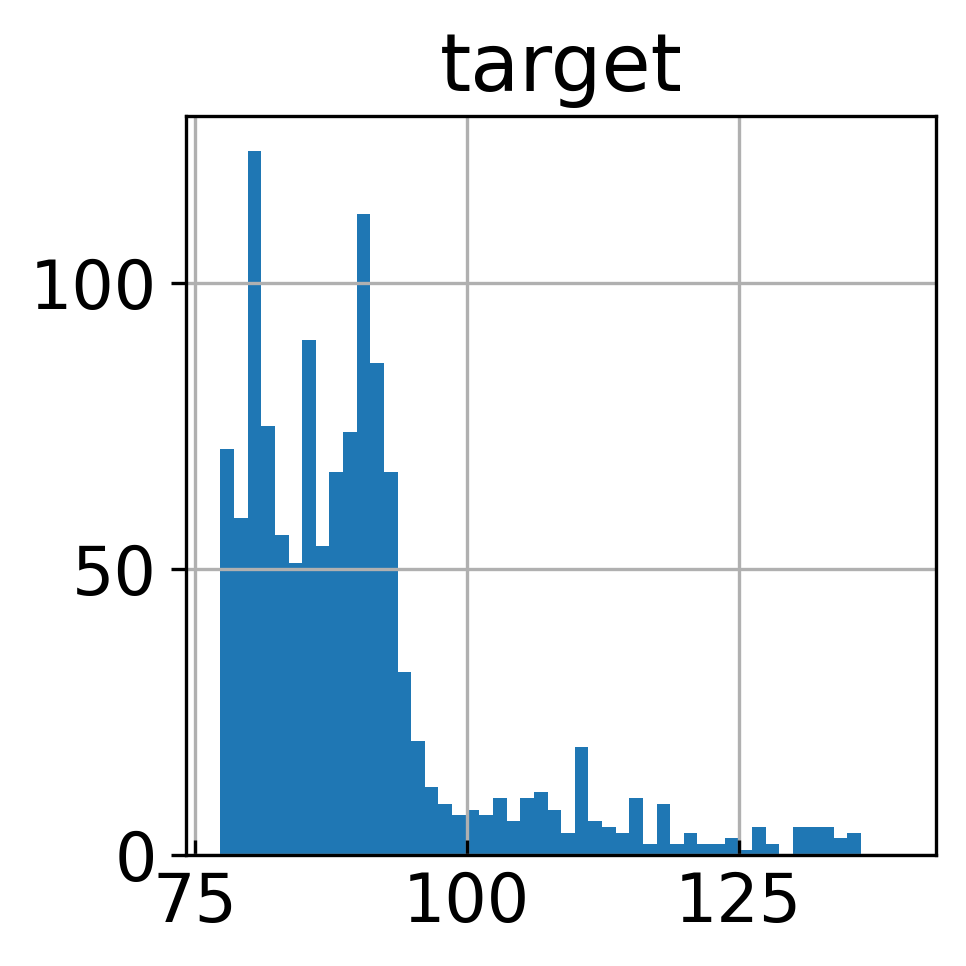

In [ ]:
#Histogram of train_df with critical temperatures above 77.36 which is the range for high-temperature superconductors

hist = train_df.hist(column='target', bins=50, range=[77.36,140], align='mid')

There are 335 predicted high-temp superconductors with a critical temperatures above 77.36 K


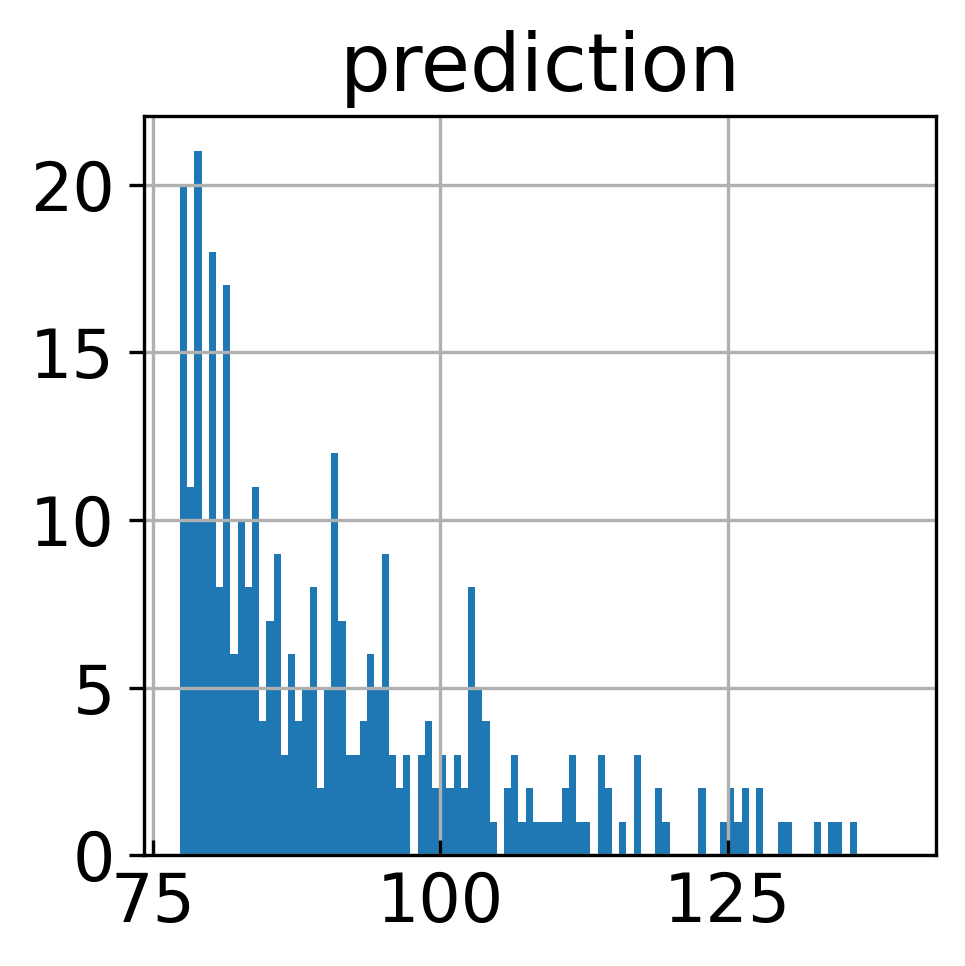

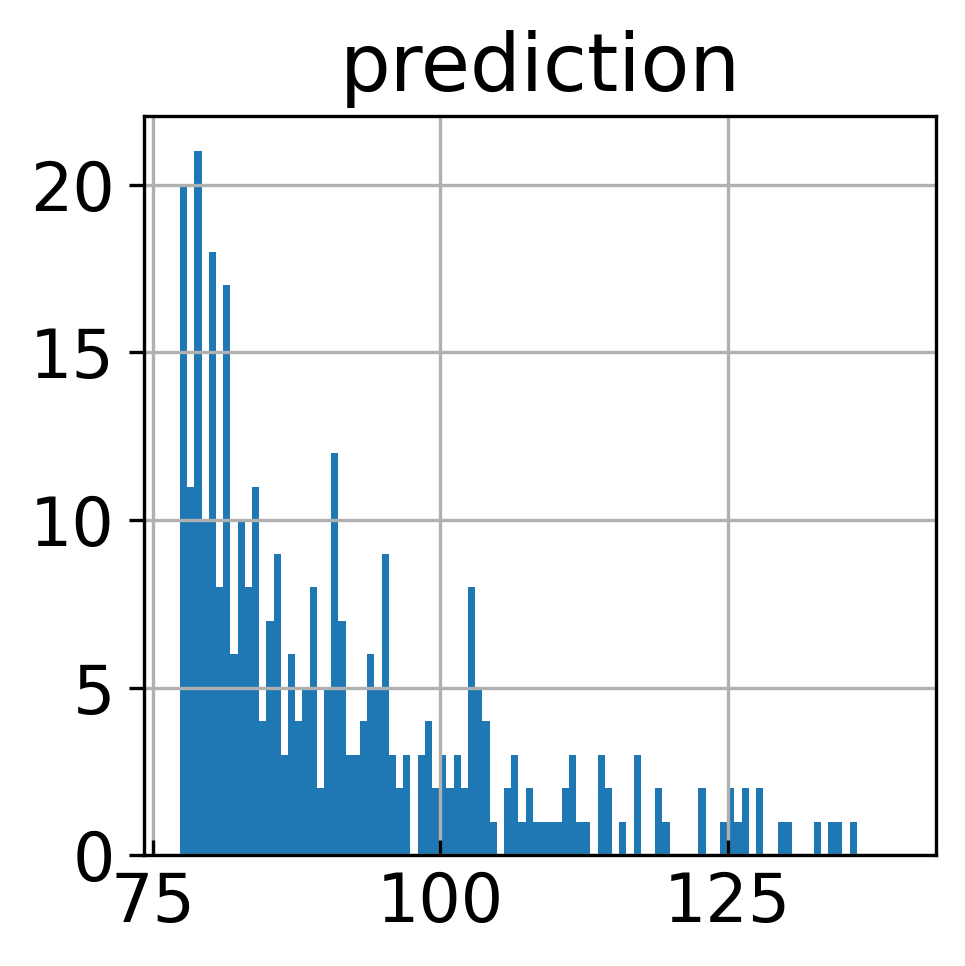

In [ ]:
#histograms for predictions

dens_hist = dens_score_df.hist(column='prediction', bins=100 ,align='mid', range= [77.36,140])

peak_hist = peak_score_df.hist(column='prediction', bins=100 ,align='mid', range= [77.36,140])

print(f"There are {(peak_score_df['prediction'] >= 77.36).sum()} predicted high-temp superconductors with a critical temperatures above 77.36 K")